In [181]:
# Load Neccessary Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import caffe
import num_recog
reload(num_recog)

<module 'num_recog' from 'num_recog.pyc'>

In [182]:
# Load caffe model
caffe.set_mode_cpu()

net = caffe.Net('./model/lenet.prototxt',
                './model/mnist_iter_20000.caffemodel',
               caffe.TEST)

img = cv2.imread('./test10.jpg')


In [183]:
def swap(a,b):
    return b,a

def get_size(cv2_img):
    return (len(cv2_img[0]), len(cv2_img)) #width, height

def pad_diggit(img):
    w, h = img.shape[1], img.shape[0]
    length = int(h * 1.4)
    v_pad = int((length - h) / 2)
    h_pad = int((length - w) / 2)
    new_img = cv2.copyMakeBorder(img, v_pad, v_pad, h_pad, h_pad, borderType=cv2.BORDER_CONSTANT, value=0)
    #new_img = cv2.resize(new_img, (8, 8))
    return cv2.resize(new_img, (28,28))

'''
Sort a four-point arrary with respect to its relative spatial location

Output: [pt1, pt2, pt3, pt4]
Satifying the following spatial condition: |pt1 pt2|
                                           |pt3 pt4|
'''
def rank(dig_ids, contours_array):
    assert len(contours_array) == 9
    unranked_list = [[], [], []]
    for n in range(9):
        unranked_list[2 - (n / 3)].append([int(contours_array[n][0, 0]), int(contours_array[n][0, 1]), dig_ids[n]])
    ranked_list = [sorted(i, key = lambda x: x[0]) for i in unranked_list]
    ret = []
    for i in ranked_list:
        for j in i:
            ret.append(j[2])
    return ret

def mask_process(mask, points):
    kernel1 = np.ones((7,6),np.uint8)
    kernel2 = np.ones((6,6),np.uint8)
    kernel3 = np.ones((3,3),np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel2)

    y_min = min(points,key=lambda cnt: cnt[0,1])[0,1]
    y_min = int(y_min)
    x_min1 = min(points, key=lambda cnt: cnt[1,0])[1,0]
    x_min1 = int(x_min1)
    x_min2 = max(points, key=lambda cnt: cnt[0,0])[0,0]
    x_min2 = int(x_min2)
    ftr = np.ones(img.shape[0:2],np.uint8)
    ftr[y_min:-1,:] = 0
    ftr[:,0:x_min1] = 0
    ftr[:,x_min2:] = 0
    return cv2.bitwise_and(mask, mask, mask=ftr)

def sort_points(rect):
    x_sort = np.array(sorted(rect, key=lambda x: x[1]))
    if x_sort[0,0] > x_sort[1,0]:
        x_sort[0,0], x_sort[1,0] = swap(x_sort[0,0], x_sort[1,0])
    if x_sort[2,0] > x_sort[3,0]:
        x_sort[2,0], x_sort[3,0] = swap(x_sort[2,0], x_sort[3,0])
    return x_sort

def find_contour_bound(cont, raw_cont = False):
    if raw_cont: cont = cont[:,0]
    left_bound = min(cont, key = lambda x: x[0])[0]
    right_bound = max(cont, key = lambda x: x[0])[0]
    lower_bound = min(cont, key = lambda x: x[1])[1]
    upper_bound = max(cont, key = lambda x: x[1])[1]
    return (left_bound, right_bound, lower_bound, upper_bound)

# Load image and compute its threshold binary map

def filterRects(rect, pure_cont = False):
    if pure_cont:
        left_bound, right_bound, lower_bound, upper_bound = find_contour_bound(rect[:,0])
    else:
        left_bound, right_bound, lower_bound, upper_bound = find_contour_bound(rect)
    x = right_bound - left_bound
    y = float(upper_bound) - lower_bound
    if y / x >= 0.3 and y / x <= 0.6:
        return True
    return False

(960, 1280, 3)


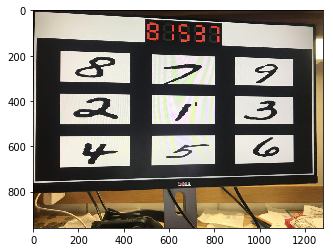

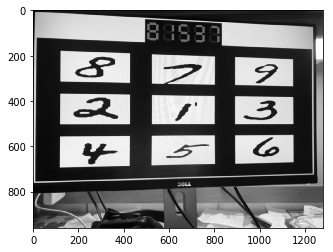

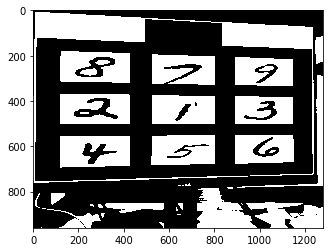

In [184]:
# Load image and compute its threshold binary map
print img.shape
img_cp = img.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7,7), 0)
ret3,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.imshow(cv2.cvtColor(img_cp, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(gray, cmap='gray')
plt.show()
plt.imshow(thresh, cmap='gray')
plt.show()

In [185]:
# Find all contours
im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
# Filter out contours that are either too big or too small
width, height = get_size(img)
img_width_range = (0.125 * width, 0.3 * width)
img_height_range = (0.1 * height, 0.18 * height)
#contours = [cnt for cnt in contours if cv2.contourArea(cnt) >= 100*40 and cv2.contourArea(cnt) <= 300*150]
contours = [cnt for cnt in contours if cv2.contourArea(cnt) >= img_width_range[0] * img_height_range[0] and cv2.contourArea(cnt) <= img_width_range[1] * img_height_range[1] and filterRects(cnt, pure_cont = True)]
# Find contour approximation and enforce a 4-sided convex shape
tmp = []
for cnt in contours:
    epsilon = 0.05*cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt,epsilon,True)
    if len(approx) == 4 and cv2.isContourConvex(approx):
        tmp.append(approx)

assert len(tmp) > 0

print "this is len of contours " + str(len(contours))
print "This one is tmp " + str(len(tmp))
if len(tmp) == 8:
    print "Manually fixing..."
    tmp = []
    for cnt in contours:
        left, right, lower, upper = find_contour_bound(cnt[:,0])
        box = [[left, lower], [right, lower], [right, upper], [left, upper]]
        tmp.append(box)
    while len(tmp) > 9:
        tmp.remove(max(tmp, key = lambda x: x[2][1])) #remove highest contour
    contours = np.array(tmp)
else:
    contours = np.array(tmp)[:,:,0,:]

dump = cv2.drawContours(img, contours, -1, (0,255,0), 3)

this is len of contours 10
This one is tmp 8
Manually fixing...


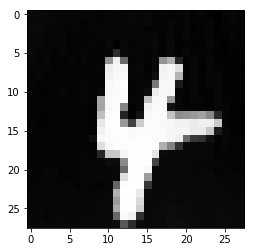

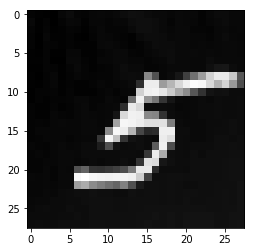

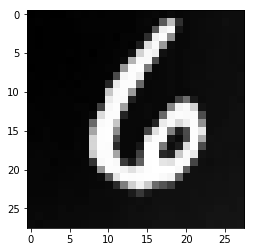

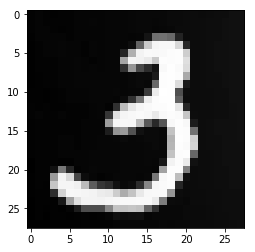

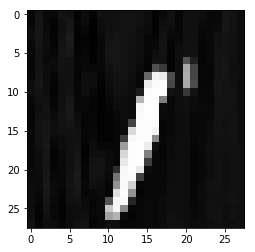

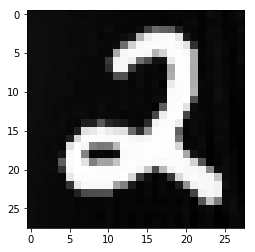

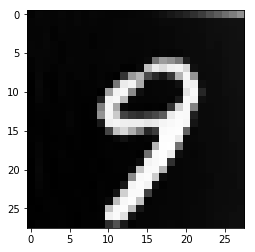

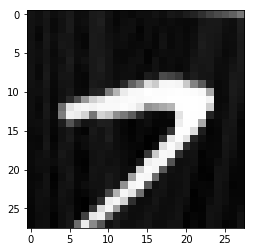

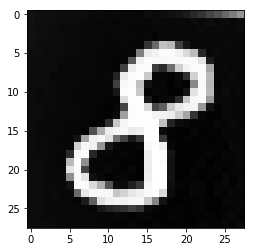

In [186]:
BOX_LEN = 32                # bounding box length for digits
offset = (BOX_LEN - 28) / 2 # calculated padding length
# Destination Points
dstpts = np.array([[0,0],[BOX_LEN,0],[0,BOX_LEN],[BOX_LEN,BOX_LEN]], dtype='float32')

bboxs = []
points = []
dynamic_height = []

for cnt in contours:
    # Sort points with respect to relative location
    pts1 = sort_points(cnt).astype('float32')
    points.append(pts1)
    # Geometric transformation that project the 4-sided shape onto a 32x32 grid
    M = cv2.getPerspectiveTransform(pts1,dstpts)
    new_img = cv2.warpPerspective(gray,M,(BOX_LEN,BOX_LEN))
    new_img = 255 - new_img[offset:-offset, offset:-offset]
    bboxs.append(new_img)
    plt.imshow(bboxs[-1], cmap='gray')
    plt.show()
    left, right, lower, upper = find_contour_bound(cnt)
    dynamic_height.append(int(upper - lower))
    

bboxs = np.array(bboxs)[:, None,...]

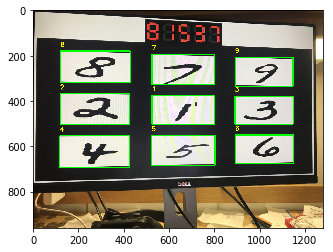

In [187]:
net.blobs['data'].reshape(bboxs.shape[0], 1, 28, 28)
net.blobs['data'].data[...] = bboxs.astype('float32') / 255
out = net.forward()
dig_ids = out['prob'].argmax(axis = 1)
a = out['prob']
for i in range(len(points)):
    cv2.putText(img, str(dig_ids[i]),
                (int(points[i][0,0]), int(points[i][0,1]-20)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.9,
               (0,255,255),
               2,cv2.LINE_AA)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

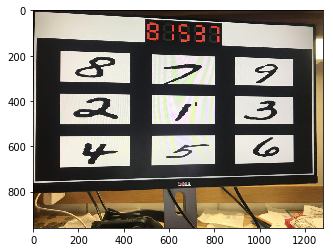

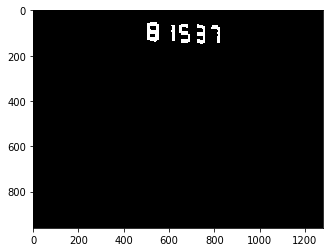

In [188]:
org_img = img_cp.copy()
hsv_img = cv2.cvtColor(org_img, cv2.COLOR_BGR2HSV)
lower_red = np.array([0,90,70])
upper_red = np.array([15,255,255])
mask = cv2.inRange(hsv_img, lower_red, upper_red)
mask1 = cv2.inRange(hsv_img, lower_red, upper_red)
lower_red = np.array([155,90,70])
upper_red = np.array([179,255,255])
mask2 = cv2.inRange(hsv_img, lower_red, upper_red)
mask = np.bitwise_or(mask1, mask2)
org_2_img = mask.copy()

#dilation
digit_height = int(dynamic_height[len(dynamic_height) // 2] * (0.58))
kernel = np.ones((int(digit_height / 10), 1), np.uint8)
mask = cv2.dilate(mask, kernel, iterations = 1)
#kernel = np.ones((5, 1), np.uint8)
#mask = cv2.dilate(mask, kernel, iterations = 1)

mask = mask_process(mask, points)
mask_w_o_dilation = mask_process(org_2_img, points)

im2, sct_cnts, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
rects = [cv2.boundingRect(cnt) for cnt in sct_cnts]
rects = [rect for rect in rects if rect[2] < rect[3]]
plt.imshow(cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(mask, cmap='gray')
plt.show()

In [189]:
def pad_diggit(img):
    w, h = img.shape[1], img.shape[0]
    length = int(h * 1.4)
    v_pad = int((length - h) / 2)
    h_pad = int((length - w) / 2)
    new_img = cv2.copyMakeBorder(img, v_pad, v_pad, h_pad, h_pad, borderType=cv2.BORDER_CONSTANT, value=0)
    #new_img = cv2.resize(new_img, (8, 8))
    return cv2.resize(new_img, (28,28))

63
52
64
60
63
67
5
52 505 52 87
(8, 5, 12, 18)


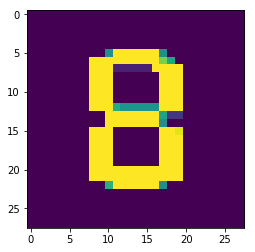

64 610 15 74
(13, 5, 3, 18)


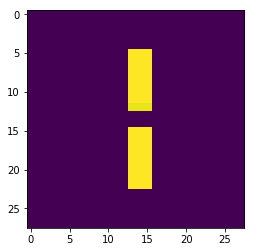

60 643 50 85
(8, 4, 12, 20)


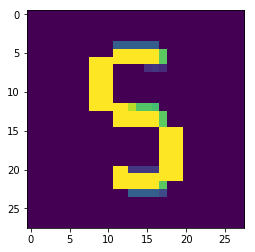

63 722 38 85
(9, 4, 10, 20)


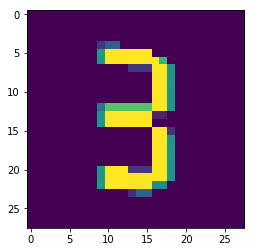

67 787 40 79
(9, 4, 10, 20)


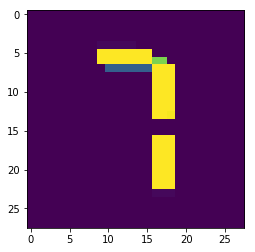

In [190]:
rects = sorted(rects, key=lambda x: x[0])
y = sorted(rects, key=lambda x: x[1])
y = y[len(y)/2][1]
print y
for i in rects:
    print i[1]
rects = [rect for rect in rects if rect[1] >= y*0.8 and rect[1] <= y*1.23]
print len(rects)
#kernel = np.ones((2, 1), np.uint8)
#mask_w_o_dilation = cv2.dilate(mask, kernel, iterations = 1)
for rect in rects:
    print rect[1], rect[0], rect[2], rect[3]
    aa = pad_diggit(mask_w_o_dilation[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]])
    x, y, w, h = cv2.boundingRect(aa)
    print (x,y,w,h)
    #cv2.rectangle(aa, (x, y), (x + w, y + h), (255, 0, 0), 2)
    plt.imshow(aa)
    plt.show()

Current ((8, 7), (10, 12))
Current Area Protion1.0
Current ((8, 15), (10, 20))
Current Area Protion1.0
Current ((18, 7), (19, 12))
Current Area Protion1.0
Current ((18, 15), (19, 21))
Current Area Protion1.0
Current ((10, 5), (17, 6))
Current Area Protion0.857142857143
Current ((10, 14), (18, 15))
Current Area Protion0.875
Current ((10, 21), (18, 23))
Current Area Protion0.875


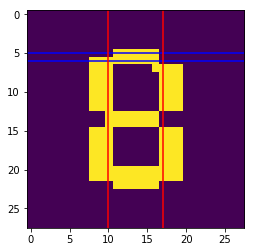

[1, 1, 1, 1, 1, 1, 1]
Current ((8, 7), (10, 12))
Current Area Protion1.0
Current ((8, 15), (10, 20))
Current Area Protion0.0
Current ((18, 7), (19, 12))
Current Area Protion0.0
Current ((18, 15), (19, 21))
Current Area Protion1.0
Current ((10, 5), (17, 6))
Current Area Protion0.857142857143
Current ((10, 14), (18, 15))
Current Area Protion0.75
Current ((10, 21), (18, 23))
Current Area Protion0.8125


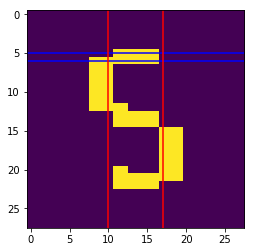

[1, 0, 0, 1, 1, 1, 1]
Current ((10, 7), (12, 12))
Current Area Protion0.0
Current ((10, 15), (12, 20))
Current Area Protion0.0
Current ((16, 7), (17, 12))
Current Area Protion1.0
Current ((16, 15), (17, 21))
Current Area Protion1.0
Current ((12, 5), (15, 6))
Current Area Protion1.0
Current ((12, 14), (16, 15))
Current Area Protion1.0
Current ((12, 21), (16, 23))
Current Area Protion1.0


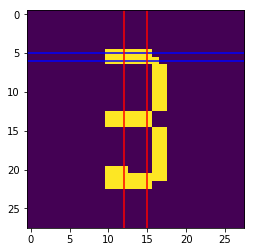

[0, 0, 1, 1, 1, 1, 1]
Current ((9, 7), (11, 12))
Current Area Protion0.0
Current ((9, 15), (11, 20))
Current Area Protion0.0
Current ((17, 7), (18, 12))
Current Area Protion1.0
Current ((17, 15), (18, 21))
Current Area Protion0.833333333333
Current ((11, 5), (16, 6))
Current Area Protion1.0
Current ((11, 14), (17, 15))
Current Area Protion0.0
Current ((11, 21), (17, 23))
Current Area Protion0.166666666667


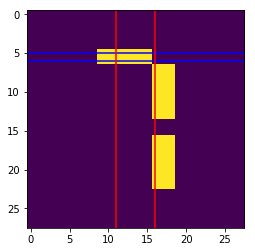

[0, 0, 1, 1, 1, 0, 0]
[8, 1, 5, 3, 7]


In [191]:
secret_ids = []
for rect in rects:
    if mask_w_o_dilation[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]].mean() > 240:
        secret_ids.append(1)
    else:
        secret_ids.append(num_recog.digit_recognition(pad_diggit(mask_w_o_dilation[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]])))
print secret_ids

In [192]:
secrets = np.array([pad_diggit(mask[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]]) for rect in rects], dtype='float32')
secrets = secrets[:,None,...].astype('float32') / 255
net.blobs['data'].reshape(secrets.shape[0], 1, 28, 28)
net.blobs['data'].data[...] = secrets
out = net.forward()
dig_ids = out['prob'].argmax(axis = 1)
print dig_ids

[8 1 5 3 7]
